In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

signal_real = pd.read_csv("./combined-dataset/real-signal-injected.csv", header=None).astype(float)
signal_syn = pd.read_csv("./combined-dataset/synthetic-signal-injected.csv", header=None).astype(float)
noise_real = pd.read_csv("./combined-dataset/real-noise.csv", header=None).astype(float)
noise_syn = pd.read_csv("./combined-dataset/synthetic-noise.csv", header=None).astype(float)

signal_real["label"] = 1
signal_syn["label"] = 1
noise_real["label"] = 0
noise_syn["label"] = 0

train_data = pd.concat([signal_real, signal_syn, noise_real, noise_syn], axis = 0)
train_data = shuffle(train_data, random_state = 42)

X = train_data.iloc[:, :-1].values
y = train_data["label"].values.astype(np.float32)

noise_all = pd.concat([noise_real, noise_syn], axis = 0)

scaler = StandardScaler()
scaler.fit(noise_all.iloc[:, :-1])
X = scaler.transform(X)

X = np.expand_dims(X, axis=-1)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU,
                                     MaxPooling1D, Dropout, Bidirectional, GRU,
                                     GlobalAveragePooling1D, Dense)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

def build_cnn_bigru(input_shape=(16384, 1),
                    conv_filters=(32, 64, 128),
                    kernels=(15, 9, 7),
                    pools=(4, 4, 4),
                    rnn_units=64,
                    dropout=0.3,
                    lr=3e-4):
    inp = Input(shape=input_shape)
    x = inp

    # ----- CNN feature extractor -----
    for f, k, p in zip(conv_filters, kernels, pools):
        x = Conv1D(f, k, padding="same")(x)
        x = BatchNormalization()(x)      
        x = ReLU()(x)
        x = MaxPooling1D(pool_size=p)(x)
        x = Dropout(0.1)(x)

    # ----- Bidirectional GRU -----
    x = Bidirectional(GRU(rnn_units, return_sequences=True))(x)
    x = BatchNormalization()(x)          
    x = GlobalAveragePooling1D()(x)      
    x = Dropout(dropout)(x)

    # ----- Output layer -----
    out = Dense(1, activation="sigmoid")(x)

    model = Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

early_stop = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
lr_plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Build and train
cnn_bigru = build_cnn_bigru()
history = cnn_bigru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, lr_plateau],
    verbose=1
)

# Predictions
y_pred = cnn_bigru.predict(X_val).ravel()


Epoch 1/30
448/448 [==============================] - 43s 80ms/step - loss: 0.7280 - accuracy: 0.5189 - auc: 0.5226 - val_loss: 0.8153 - val_accuracy: 0.5092 - val_auc: 0.6076 - lr: 3.0000e-04
Epoch 2/30
448/448 [==============================] - 35s 78ms/step - loss: 0.5868 - accuracy: 0.6629 - auc: 0.7352 - val_loss: 0.8304 - val_accuracy: 0.6540 - val_auc: 0.8547 - lr: 3.0000e-04
Epoch 3/30
448/448 [==============================] - 35s 78ms/step - loss: 0.4490 - accuracy: 0.7513 - auc: 0.8565 - val_loss: 0.4313 - val_accuracy: 0.7475 - val_auc: 0.8934 - lr: 3.0000e-04
Epoch 4/30
448/448 [==============================] - 35s 79ms/step - loss: 0.3909 - accuracy: 0.7836 - auc: 0.8922 - val_loss: 0.3920 - val_accuracy: 0.7693 - val_auc: 0.9170 - lr: 3.0000e-04
Epoch 5/30
448/448 [==============================] - 35s 79ms/step - loss: 0.3709 - accuracy: 0.7955 - auc: 0.9029 - val_loss: 0.4497 - val_accuracy: 0.7874 - val_auc: 0.9069 - lr: 3.0000e-04
Epoch 6/30
448/448 [===============

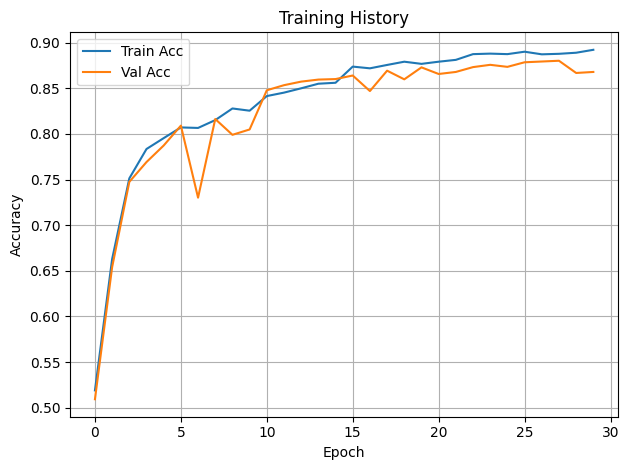

ROC AUC Score: 0.9550884013273278
              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88      1792
         1.0       0.97      0.76      0.85      1792

    accuracy                           0.87      3584
   macro avg       0.89      0.87      0.87      3584
weighted avg       0.89      0.87      0.87      3584


Confusion Matrix (counts):
[[1754   38]
 [ 435 1357]]

Rates:
  TPR (Recall)      : 0.7573
  FPR               : 0.0212
  TNR (Specificity) : 0.9788
  FNR               : 0.2427


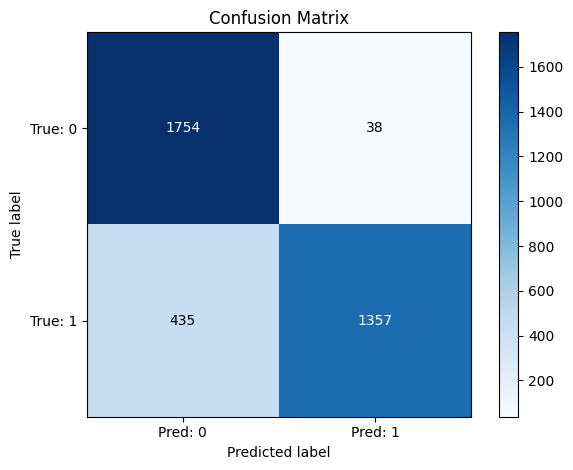

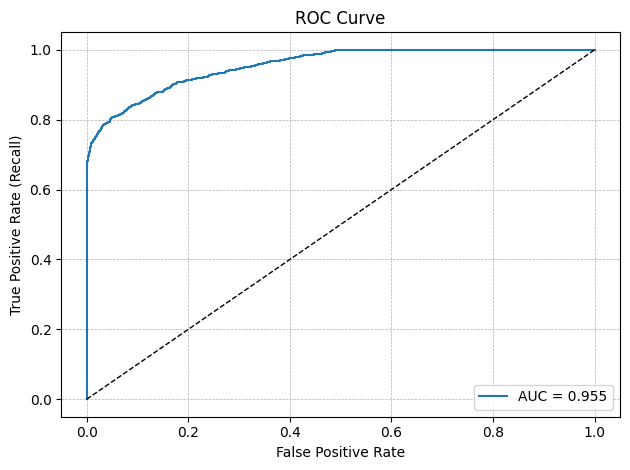

Gini Coefficient: 0.9102
Jaccard Score: 0.7415


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score,
    jaccard_score
)

# Accuracy history plot
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Core text metrics
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

#Confusion matrix + rates
y_pred_labels = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred_labels)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix (counts):")
print(cm)

# Rates
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Recall / Sensitivity
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # Specificity
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

print("\nRates:")
print(f"  TPR (Recall)      : {tpr:.4f}")
print(f"  FPR               : {fpr:.4f}")
print(f"  TNR (Specificity) : {tnr:.4f}")
print(f"  FNR               : {fnr:.4f}")

# Confusion matrix heatmap
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["Pred: 0", "Pred: 1"])
plt.yticks(ticks, ["True: 0", "True: 1"])

# draw numbers
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

#ROC curve + AUC + Gini
fpr_curve, tpr_curve, _ = roc_curve(y_val, y_pred)
auc_val = roc_auc_score(y_val, y_pred)
gini = 2 * auc_val - 1

plt.figure()
plt.plot(fpr_curve, tpr_curve, label=f"AUC = {auc_val:.3f}")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


print(f"Gini Coefficient: {gini:.4f}")

#Jaccard + Precision–Recall curve
jac = jaccard_score(y_val, y_pred_labels)
print(f"Jaccard Score: {jac:.4f}")

In [5]:
cnn_bigru.save("final_combined_cnn_gru_model.h5")